<a href="https://colab.research.google.com/github/kiakass/recommendation/blob/main/CF_recommandation_ICF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from surprise import Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#!pip install surprise

In [ ]:
movies_fn = ('https://raw.githubusercontent.com/kiakass/share/master/movies.csv')   # 9,125 건, 
ratings_fn = ('https://raw.githubusercontent.com/kiakass/share/master/ratings.csv') # 100,004 건, C:/03.DATA/recommend/ratings.csv

In [ ]:
movies=pd.read_csv(movies_fn)
ratings=pd.read_csv(ratings_fn)

In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [ ]:
pd.merge(ratings, movies, on='movieId')

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,7,31,3.0,851868750,Dangerous Minds (1995),Drama
2,31,31,4.0,1273541953,Dangerous Minds (1995),Drama
3,32,31,4.0,834828440,Dangerous Minds (1995),Drama
4,36,31,3.0,847057202,Dangerous Minds (1995),Drama
...,...,...,...,...,...,...
99999,664,64997,2.5,1343761859,War of the Worlds (2005),Action|Sci-Fi
100000,664,72380,3.5,1344435977,"Box, The (2009)",Drama|Horror|Mystery|Sci-Fi|Thriller
100001,665,129,3.0,995232528,Pie in the Sky (1996),Comedy|Romance
100002,665,4736,1.0,1010197684,Summer Catch (2001),Comedy|Drama|Romance


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### 특정 user 기준 data 보기

In [ ]:
# 데이터프레임에서 한 컬럼만 뽑아낸 시리즈를 종류별로 카운트하고, 인덱스에 따라 내림차순 정렬
data = ratings['rating'].value_counts().sort_index(ascending=True)
ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating',ascending=False)

,userId,rating
546,547,2391
563,564,1868
623,624,1735
14,15,1700
72,73,1610
...,...,...
295,296,20
288,289,20
248,249,20
220,221,20


In [ ]:
data

0.5     1101
1.0     3326
1.5     1687
2.0     7271
2.5     4449
3.0    20064
3.5    10538
4.0    28750
4.5     7723
5.0    15095
Name: rating, dtype: int64

<AxesSubplot:>

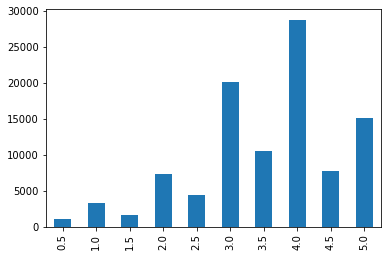

In [ ]:
data.plot.bar()

### Data 처리

In [ ]:
user_movie_rating = pd.merge(ratings,movies)
user_movie_rating.head()

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,7,31,3.0,851868750,Dangerous Minds (1995),Drama
2,31,31,4.0,1273541953,Dangerous Minds (1995),Drama
3,32,31,4.0,834828440,Dangerous Minds (1995),Drama
4,36,31,3.0,847057202,Dangerous Minds (1995),Drama


In [ ]:
movie_user_rating = pd.merge(movies,ratings)

In [ ]:
movie_rating_matrix= user_movie_rating.pivot_table('rating', index='title', columns='userId')
movie_rating_matrix.fillna(0, inplace=True)
movie_rating_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$9.99 (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Neath the Arizona Skies (1934),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_rating_matrix = user_movie_rating.pivot_table('rating', index='userId', columns='title')
user_rating_matrix.fillna(0, inplace=True)
user_rating_matrix.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
movie_imiilarity=cosine_similarity(movie_rating_matrix)
movie_imiilarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , ..., 0.05821787, 0.        , 0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.05821787, 0.        , ..., 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 1.        ]])

In [ ]:
icf=pd.DataFrame(movie_imiilarity, index=movie_rating_matrix.index, columns=movie_rating_matrix.index)
icf

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",1.000000,0.000000,0.0,0.164399,0.020391,0.0,0.014046,0.000000,0.000000,0.003166,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0000
$9.99 (2008),0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.079474,0.000000,0.156330,...,0.000000,0.000000,0.0,0.000000,0.0,0.013899,0.000000,0.058218,0.0,0.0000
'Hellboy': The Seeds of Creation (2004),0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.217357,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0000
'Neath the Arizona Skies (1934),0.164399,0.000000,0.0,1.000000,0.124035,0.0,0.085436,0.000000,0.000000,0.019259,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0000
'Round Midnight (1986),0.020391,0.000000,0.0,0.124035,1.000000,0.0,0.010597,0.143786,0.000000,0.136163,...,0.000000,0.000000,0.0,0.121567,0.0,0.000000,0.000000,0.000000,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xXx (2002),0.000000,0.013899,0.0,0.000000,0.000000,0.0,0.000000,0.123940,0.000000,0.144961,...,0.161281,0.076029,0.0,0.017465,0.0,1.000000,0.152057,0.140222,0.0,0.2661
xXx: State of the Union (2005),0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.134815,...,0.000000,0.000000,0.0,0.000000,0.0,0.152057,1.000000,0.000000,0.0,0.0000
¡Three Amigos! (1986),0.000000,0.058218,0.0,0.000000,0.000000,0.0,0.081620,0.331663,0.214498,0.064908,...,0.112588,0.159223,0.0,0.166622,0.0,0.140222,0.000000,1.000000,0.0,0.0000


In [ ]:
def get_icf_movie(title,cnt):
    return icf[title].sort_values(ascending=False)[:cnt+1]

In [ ]:
get_icf_movie('Apocalypse Now (1979)',10)

title
Apocalypse Now (1979)                     1.000000
Full Metal Jacket (1987)                  0.599113
Clockwork Orange, A (1971)                0.589708
One Flew Over the Cuckoo's Nest (1975)    0.549784
Jaws (1975)                               0.545789
Raising Arizona (1987)                    0.539118
Goodfellas (1990)                         0.538783
Platoon (1986)                            0.536771
Godfather, The (1972)                     0.534347
Reservoir Dogs (1992)                     0.531213
Big Lebowski, The (1998)                  0.529501
Name: Apocalypse Now (1979), dtype: float64

### User 시청 정보 요약 

In [ ]:
import numpy as np
np.set_printoptions(linewidth=np.inf)

In [ ]:
# userId 시청 영화 확인
def userId_wtch_movies(userId,cnt):
    userId_genre=pd.DataFrame()
    userId_genre['genre_rating']=pd.merge(ratings[(ratings['userId'] == userId)],movies, on='movieId').groupby('genres')['rating'].mean()
    userId_genre['genre_cnt']=pd.merge(ratings[(ratings['userId'] == userId)],movies, on='movieId').groupby('genres')['rating'].count()
    userId_genre_r = userId_genre.sort_values('genre_cnt',ascending=False)
    
    userId_movie_l = \
    pd.merge(ratings[(ratings['userId'] == userId)].sort_values('rating',ascending=False).head(cnt),movies, on='movieId')
    
    return userId_genre_r, userId_movie_l


genre,wtch=userId_wtch_movies(266,20)


print(genre ,'\n')
wtch
#data = ratings['rating'].value_counts().sort_index(ascending=True)
#ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating',ascending=False)
#pd.merge(ratings[(ratings['userId'] == 266)].sort_values('rating',ascending=False).head(20),movies, on='movieId')

                                                 genre_rating  genre_cnt
genres                                                                  
Drama                                                3.833333          6
Drama|Thriller                                       3.000000          2
Action|Crime|Thriller                                3.000000          2
Crime|Drama                                          4.500000          2
Comedy|Romance                                       4.000000          2
Comedy|Drama                                         3.000000          2
Action|Adventure|Comedy|Romance|Thriller             3.000000          1
Comedy|Crime|Drama|Thriller                          3.000000          1
Drama|War                                            5.000000          1
Drama|Romance                                        3.000000          1
Crime|Mystery|Thriller                               4.000000          1
Crime|Horror|Thriller                              

,userId,movieId,rating,timestamp,title,genres
0,266,838,5.0,840703429,Emma (1996),Comedy|Drama|Romance
1,266,36,5.0,840703429,Dead Man Walking (1995),Crime|Drama
2,266,39,5.0,840703309,Clueless (1995),Comedy|Romance
3,266,590,5.0,840452108,Dances with Wolves (1990),Adventure|Drama|Western
4,266,150,5.0,840452108,Apollo 13 (1995),Adventure|Drama|IMAX
5,266,527,5.0,840452291,Schindler's List (1993),Drama|War
6,266,457,5.0,840703189,"Fugitive, The (1993)",Thriller
7,266,300,5.0,840703263,Quiz Show (1994),Drama
8,266,364,5.0,840703263,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
9,266,318,4.0,840452329,"Shawshank Redemption, The (1994)",Crime|Drama


In [ ]:
genre

,genre_rating,genre_cnt
genres,,
Drama,3.833333,6
Drama|Thriller,3.000000,2
Action|Crime|Thriller,3.000000,2
Crime|Drama,4.500000,2
Comedy|Romance,4.000000,2
Comedy|Drama,3.000000,2
Action|Adventure|Comedy|Romance|Thriller,3.000000,1
Comedy|Crime|Drama|Thriller,3.000000,1
Drama|War,5.000000,1
